In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering

In [40]:
bpath = Path('../data/clustering/BNU1/similarities/')
sims = {_: pd.read_hdf(_) for _ in bpath.rglob('*similarity*h5')}
cons = {_: pd.read_hdf(_) for _ in bpath.rglob('*consistency*h5')}
dists = {tuple(_.name.split('_')[0:2]): np.loadtxt(_) for _ in bpath.rglob('*distmat*txt')}

In [41]:
def meta_stack(kvp):
    df = None
    for k, v in kvp.items():
        dset, atlas = tuple(k.name.split('_')[0:2])
        v['dataset'] = dset
        v['atlas'] = atlas
        df = pd.concat([df, v])
    return df

df_sim = meta_stack(sims)
df_con = meta_stack(cons)

In [95]:
def cluster_and_plot(df_sim, dmat):
    dmat = 1-dmat
    clf = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                  linkage='average',
                                  distance_threshold=np.percentile(dmat, 50))
    labs = clf.fit_predict(dmat)
    unique, counts = np.unique(labs, return_counts=True)
    n_significant = sum([1 for _ in counts if _ > 1])

    fig = plt.figure(figsize=(10, n_significant*5))

    clustering = []
    col = 0
    for l, c in zip(unique, counts):
        locs = np.where(labs == l)
        if c < 2:
            continue
        else:
            col += 1
        tdf = df_sim.iloc[locs]
        signature = np.mean(tdf['rank_corr'])
        clustering += [{
            'label': l,
            'members': locs,
            'signature': signature
        }]
        
        plt.subplot(1, n_significant, col)
        plt.xlabel('Label: {0}  |  N: {1}'.format(l, len(locs[0])))
        plt.imshow(signature)

    plt.show()
    return clustering

<ipython-input-95-0b674b022e89>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-95-0b674b022e89>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-95-0b674b022e89>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-95-0b674b022e89>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5050 100 (100, 100)
5050 100 (100, 100)
5050 100 (100, 100)
5050 100 (100, 100)


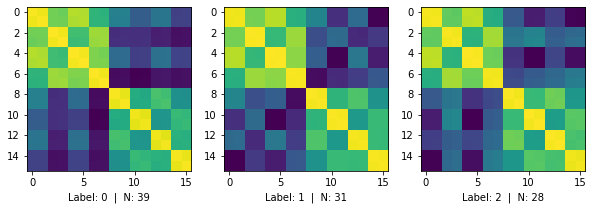

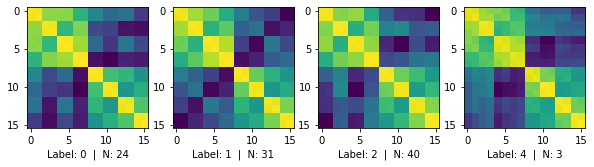

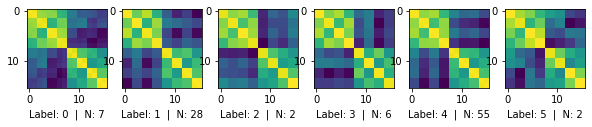

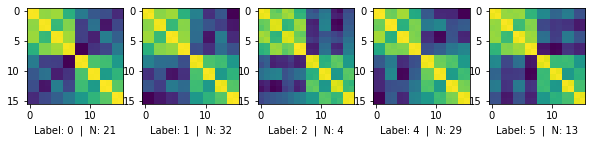

In [96]:
combos = df_sim.value_counts(['dataset', 'atlas']).index
sliced = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]

for ds, at in combos:
    tdf_c = sliced(df_con, ds, at)
    tdf_s = sliced(df_sim, ds, at)
    tdmat = dists[(ds, at)]
    cluster_and_plot(tdf_s, tdmat)
    print(len(tdf_c), len(tdf_s), tdmat.shape)